# A simple autoencoder from scratch using the contrib layers of tensorflow

In [1]:
%matplotlib inline
import os
import socket
import pickle

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-pastel')

In [2]:
comp_name=socket.gethostname()
if 'manu' in comp_name:
    gpus = [1]
    os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [3]:
def cross_entropy(x_, x, offset=1e-7):
    with tf.name_scope('cross_entropy'):
        x__ = tf.clip_by_value(x_, offset, 1 - offset)
        return -tf.reduce_sum(x * tf.log(x__) + (1 - x) * tf.log(1 - x_), 1)

def square_distence(x_, x, offset=1e-7):
    x__ = tf.clip_by_value(x_, offset, 1 - offset)
    return -0.5*tf.reduce_sum(tf.square(x - x__), 1)

def kl_distance(mu, log_sigma):
    with tf.name_scope('KL_divergence'):
        return -0.5 * tf.reduce_sum(1 + 2 * log_sigma - mu**2 - tf.exp(2 * log_sigma), 1)
    
        
class VariationalAutoEncoder(object):
    DEFAULTS = {
        "batch_size": 128,
        "learning_rate": 5E-4,
        "dropout": 0.9,
        "lambda_l2_reg": 1E-5,
        "nonlinearity": tf.nn.elu,
        "squashing": tf.nn.sigmoid,
        "regularization": tf.contrib.layers.l2_regularizer,
        "mu": 0,
        "sigma": .1,
    }
    RESTORE_KEY = "to_restore"
    
    def __init__(self, architecture=[], d_hyperparams={}, log_dir='./log'):
        self.architecture = architecture
        self.__dict__.update(VariationalAutoEncoder.DEFAULTS, **d_hyperparams)
        self.sesh = tf.Session()
        #TODO: decide if load a model or build a new one. For now, build it
        handles = self._build_graph()
        
        # In any case, make a collection of variables that are restore-able
        for handle in handles:
            tf.add_to_collection(VariationalAutoEncoder.RESTORE_KEY, handle)
            
        self.sesh.run(tf.global_variables_initializer())

        
        # Unpack the tuple of handles created by the builder
        (self.x_in, self.z_mean, self.z_log_sigma, self.x_reconstructed, self.z, 
               self.cost, self.global_step, self.train_op, self.merged_summaries) = handles
        
        # Initialize the filewriter and write the graph (tensorboard)
        
        self.writer = tf.summary.FileWriter(log_dir, self.sesh.graph)
        
    def _build_graph(self):
        # The architecture is definded here, using contrib layers
        # Tdodo: implement a compose_layers
        
        regularizer = self.regularization(self.lambda_l2_reg)
        #regularizer = None
        # the encoder
        x_in = tf.placeholder(tf.float32, shape=[None, self.architecture[0]], name='x_in')
        x = tf.layers.dense(x_in, 1000, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_0')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e0')
        x = tf.layers.dense(x, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_1')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e1')
        x = tf.layers.dense(x, 250, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_2')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e2')
        x = tf.layers.dense(x, 50, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='enc_3')
        x = tf.layers.dropout(x, rate=self.dropout, name='drop_e3')
#         for i, dim in enumerate(self.architecture[1:-1]):
#             print('Encoder: Creating fully connected layer with sizes: IN {} - SIZE {}'.format(x.shape, dim))
#             x = tf.layers.dense(x_in, dim, activation=self.nonlinearity, name='enc_{}'.format(i))
        
        # the latent space (separate the mean and the sigma)
        z_mean = tf.layers.dense(x, self.architecture[-1], activation=self.nonlinearity, name='z_mean') 
        z_log_sigma = tf.layers.dense(x, self.architecture[-1], activation=self.nonlinearity, name='z_log_sigma')
        print('Creating fully connected latent layers with sizes {}'.format(z_mean.shape))

        # The sample from the latent space with n(0,1)
        # With a little trick. Rathern than sampling N(z_mean, z_sigma), 
        # add a gaussian noise
        eps = tf.random_normal(tf.shape(z_log_sigma), 0, self.sigma, 
                               dtype=tf.float32, name='eps')
        
        z = tf.add(z_mean, eps * tf.exp(z_log_sigma), name='z')
        
        # decoder (from z to x_out)
        h = tf.layers.dense(z, 50, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(3))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d3')
        h = tf.layers.dense(h, 250, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(2))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d2')
        h = tf.layers.dense(h, 500, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(1))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d1')
        h = tf.layers.dense(h, 1000, activation=self.nonlinearity, 
                            kernel_regularizer=regularizer,
                            name='dec_{}'.format(0))
        h = tf.layers.dropout(h, rate=self.dropout, name='drop_d0')
#         for i, dim in enumerate(self.architecture[1:-1][::-1]):
#             print('Decoder: Creating fully connected layer with sizes: IN {} - SIZE {}'.format(h.shape, dim))
#             h = tf.layers.dense(h, dim, activation=self.nonlinearity, name='dec_{}'.format(i))
        print('Created decoder layers')
        # final reconstruction with squashing to [0, 1]
        y = tf.layers.dense(h, self.architecture[0], activation=self.squashing, 
                            kernel_regularizer=regularizer,
                            name='decoder')
        y = tf.layers.dropout(y, rate=self.dropout, name='drop_decoder')
        x_reconstructed = tf.identity(y, name='x_reconstructed')
        
        # reconstruction loss: cross-entropy
        rec_loss = cross_entropy(x_reconstructed, x_in)
        
        # square error
        #rec_loss = square_distence(x_reconstructed, x_in)
        
        # KL divergence: information loss btw X and Z representations
        kl_loss = kl_distance(z_mean, z_log_sigma)
        
        # regularization loss
        l2_loss = tf.losses.get_regularization_loss()
        
        with tf.name_scope('cost'):
            cost = tf.reduce_sum(rec_loss + kl_loss, name='vae_cost') + l2_loss
            
        # append to summary
        with tf.name_scope('summaries'):
            with tf.name_scope('loss'):
                tf.summary.scalar('kl_loss', tf.reduce_sum(kl_loss, name='kl_scalar'))
                tf.summary.scalar('rec_loss', tf.reduce_sum(rec_loss, name='rl_scalar'))
                tf.summary.scalar('cost', cost)
                tf.summary.scalar('l2_loss', l2_loss)
                tf.summary.histogram('kl_hist', kl_loss)
                tf.summary.histogram('rec_hist', rec_loss)
        
        print('created all layers')
        # The optimization
        global_step = tf.Variable(0, trainable=False)
        with tf.name_scope('AdamOptimizer'):
            optimizer = tf.train.AdamOptimizer(self.learning_rate)
            # simple optimization
            # train_op = optimizer.minimize(cost, global_step=global_step, name='minimize_cost')
            # With clipped gradients:
            train_vars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, var_list=train_vars)
            
            clipped = []
            for grad, var in grads_and_vars:
                print('var {}'.format(var))
                print('grad {}'.format(grad))
                # add histograms of gradients, per variable (?)
#                 with tf.name_scope('summaries'):
#                     with tf.name_scope('gradients'):
#                         tf.summary.histogram(grad)
                clipped.append((tf.clip_by_value(grad, -5, 5), var))
            train_op = optimizer.apply_gradients(clipped, global_step=global_step, 
                                                name='minimize_cost')
        
        merged_summaries = tf.summary.merge_all()
        # return tuple of operations
        return(x_in, z_mean, z_log_sigma, x_reconstructed, z, 
               cost, global_step, train_op, merged_summaries)
        
    def encode(self, x):
        feed_dict = {self.x_in: x}
        return self.sesh.run([self.z_mean, self.z_log_sigma], feed_dict=feed_dict)
        
    def decode(self, z):
        feed_dict = {self.z: z}
        return self.sesh.run(self.x_reconstructed, feed_dict=feed_dict)
    
    def vae(self, x):
        feed_dict = {self.x_in: x}
        return self.sesh.run([self.x_reconstructed, self.z, self.z_log_sigma], 
                             feed_dict=feed_dict)
    
    def train(self, X, max_iter=np.inf, max_epochs=np.inf, cross_validate=True, verbose=True):
        try:
            err_train = 0
            
            while True:
                x, _ = X.train_batch(self.batch_size)
                feed_dict = {self.x_in: x}
                fetches = [self.x_reconstructed, self.cost, self.global_step, self.train_op]
                x_reconstructed, cost, i, _ = self.sesh.run(fetches, feed_dict=feed_dict)

                err_train += cost
                if i % 10 == 0:  # Record summaries and test-set accuracy
                    summary = self.sesh.run(self.merged_summaries, feed_dict=feed_dict)
                    self.writer.add_summary(summary, i)
                if i%1000 and verbose:
                    print('Round {}, loss {}'.format(i, cost))
                if i>=max_iter:
                    print("final avg cost (@ step {} = epoch {}): {}".format(
                            i, 0, err_train / i))
                    try:
                        self.writer.flush()
                        self.writer.close()
                    except(AttributeError):  # not logging
                        continue
                    break
                    
        except KeyboardInterrupt:
            print("final avg cost (@ step {} = epoch {}): {}".format(
                i, 0, err_train / i))
            print("------- Training end: {} -------\n".format(now))
            
        

## Use it with spectral slices from the model

In [4]:
sweep_file = '/mnt/cube/earneodo/bci_zf/syn_sweeps/spectral_pandas_sweep_002.pickle'
import pickle
df_syn = pd.read_pickle(sweep_file)

### filter frequency bands

In [5]:
def normalize(u):
    #normalize pe column
    u_max = np.repeat(np.amax(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_min = np.repeat(np.amin(u, axis = 1, keepdims=True), u.shape[-1], axis=1)
    u_range = u_max - u_min
    u_range[u_range == 0.] = 1
    return (u - u_min)/u_range

def filter_freq_band(df, f_min=0, f_max=10000):
    f_list = np.array(df.iloc[0].freq)
    f_sel = np.where((f_list >= f_min) & (f_list <= f_max))[0]
    f_filt = f_list[f_sel]
    
    all_spec_arr = np.array(df['spectral'].tolist())
    df['spectral'] = all_spec_arr[:, f_sel].tolist()
    return f_filt, df

def filter_par_range(df, par='a', value=-0.14987, precision=1e-2):
    int_value =int(value/precision)
    return df[((df[par]/precision).astype(np.int)) == int_value]

def transform_beta(beta):
    return (-beta/(3.))

def transform_beta_inv(beta):
    return (-beta*(3.))




In [6]:
all_spectra_array = np.array(df_syn['spectral'].tolist())
#plt.plot(all_spectra[1]);
all_spectra_array.shape
print(all_spectra_array.shape)

a_value = -0.14987
f_list, filt_df = filter_freq_band(df_syn, f_min=0, f_max=10000)
df_a_line = filter_par_range(df_syn, value=a_value)
np.unique(df_a_line.a)



(160000, 86)


array([-0.14987342, -0.14886076, -0.1478481 , -0.14683544, -0.14582278,
       -0.14481013, -0.14379747, -0.14278481, -0.14177215, -0.14075949])

In [7]:
# a batch generator using pandas
def normalize(u, axis=1):
    u_max = np.repeat(np.amax(u, axis = axis, keepdims=True), u.shape[-1], axis=axis)
    u_min = np.repeat(np.amin(u, axis = axis, keepdims=True), u.shape[-1], axis=axis)
    u_range = u_max - u_min
    return (u - u_min)/u_range

class PdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.train_frame = self.data_frame[random_frac:]
        self.test_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = np.concatenate([np.array(s) for s in all_spectra], axis=1)/self.max_pow
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
    def _make_test_array(self):
        all_spectra = np.array(self.test_frame['spectral'].as_matrix())
        self.all_test_array = np.stack([np.array(s)[:,:300] for s in all_spectra], axis=0)/self.max_pow
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [self.all_train_array[:, idx].T, self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = self.all_test_array[idx]
        return test_array_batch
    
# a batch generator using pandas
class SynBatcher(PdBatcher):
    def __init__(self, data_frame, x_field=None, y_field=None, train_factor=0.9):
    
        PdBatcher.__init__(self, data_frame, 
              x_field=x_field, y_field=y_field, train_fraction=train_factor)
       
    def _make_train_array(self):
        all_spectra = (np.array(self.train_frame['spectral'].as_matrix()))
        self.all_train_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.train_label_array = np.array([self.train_frame['a'], self.train_frame['b']]).T
        
    def _make_test_array(self):
        all_spectra = (np.array(self.test_frame['spectral'].as_matrix()))
        self.all_test_array = np.stack([np.array(s) for s in all_spectra])/self.max_pow
        self.test_label_array = np.array([self.test_frame['a'], self.test_frame['b']]).T

    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[0], n).tolist()
        return [self.all_train_array[idx], self.train_label_array[idx]]
    
    def test_batch(self, n):
        idx = np.random.randint(0, self.all_test_array.shape[0], n).tolist()
        return [self.all_test_array[idx], self.test_label_array[idx]]

#pdb = PdBatcher(df.loc[df['bird'].isin(['z007', 'z020', 'z017'])])
pdb = SynBatcher(df_syn)
print(df_syn.shape)
b_size = 100
x, y = pdb.train_batch(b_size)
n_samples = pdb.all_train_array.shape[0]

(160000, 6)


In [8]:
x, y = pdb.test_batch(b_size)

In [9]:
x.shape

(100, 86)

In [10]:
y.shape

(100, 2)

In [11]:
IMG_DIM = 86

ARCHITECTURE = [IMG_DIM, # 784 pixels
                500, 500, # intermediate encoding
                20] # latent space dims
                # 50]
# (and symmetrically back out again)

HYPERPARAMS = {
    "batch_size": 128,
    "learning_rate": 5E-4,
    "dropout": 0.9,
    "lambda_l2_reg": 1E-5,
    "nonlinearity": tf.nn.elu,
    "squashing": tf.nn.sigmoid
}

MAX_ITER = 2000#2**16
MAX_EPOCHS = np.inf

LOG_DIR = "./log"
METAGRAPH_DIR = "./out"
PLOTS_DIR = "./png"

v = VariationalAutoEncoder(ARCHITECTURE, HYPERPARAMS, log_dir=LOG_DIR)


Creating fully connected latent layers with sizes (?, 20)
Created decoder layers
created all layers
var <tf.Variable 'enc_0/kernel:0' shape=(86, 1000) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_12:0", shape=(86, 1000), dtype=float32)
var <tf.Variable 'enc_0/bias:0' shape=(1000,) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/enc_0/BiasAdd_grad/tuple/control_dependency_1:0", shape=(1000,), dtype=float32)
var <tf.Variable 'enc_1/kernel:0' shape=(1000, 500) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_11:0", shape=(1000, 500), dtype=float32)
var <tf.Variable 'enc_1/bias:0' shape=(500,) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/enc_1/BiasAdd_grad/tuple/control_dependency_1:0", shape=(500,), dtype=float32)
var <tf.Variable 'enc_2/kernel:0' shape=(500, 250) dtype=float32_ref>
grad Tensor("AdamOptimizer/gradients/AddN_10:0", shape=(500, 250), dtype=float32)
var <tf.Variable 'enc_2/bias:0' shape=(250,) dtype=float32_ref>
grad Tensor("Ada

In [12]:
v.train(pdb, max_iter=MAX_ITER, max_epochs=MAX_EPOCHS, cross_validate=False, verbose=True)

Round 1, loss 7676.36572265625
Round 2, loss 7559.7587890625
Round 3, loss 7138.02099609375
Round 4, loss 6384.68603515625
Round 5, loss 5526.0947265625
Round 6, loss 4500.830078125
Round 7, loss 3503.938232421875
Round 8, loss 3006.1650390625
Round 9, loss 2541.273681640625
Round 10, loss 2242.44384765625
Round 11, loss 2152.08203125
Round 12, loss 1874.2115478515625
Round 13, loss 1738.5123291015625
Round 14, loss 1671.6961669921875
Round 15, loss 1585.65234375
Round 16, loss 1490.312744140625
Round 17, loss 1412.65625
Round 18, loss 1359.1351318359375
Round 19, loss 1303.4595947265625
Round 20, loss 1324.454833984375
Round 21, loss 1295.39208984375
Round 22, loss 1237.5181884765625
Round 23, loss 1248.0518798828125
Round 24, loss 1268.5467529296875
Round 25, loss 1228.197021484375
Round 26, loss 1186.878173828125
Round 27, loss 1203.4228515625
Round 28, loss 1165.1082763671875
Round 29, loss 1202.269287109375
Round 30, loss 1098.2421875
Round 31, loss 1125.7791748046875
Round 32, lo

Round 273, loss 422.6548156738281
Round 274, loss 453.8920593261719
Round 275, loss 431.1026306152344
Round 276, loss 464.3695983886719
Round 277, loss 438.6636962890625
Round 278, loss 458.6098327636719
Round 279, loss 477.5235290527344
Round 280, loss 416.2597961425781
Round 281, loss 438.3734130859375
Round 282, loss 460.1606750488281
Round 283, loss 451.8279113769531
Round 284, loss 442.3861999511719
Round 285, loss 431.9678955078125
Round 286, loss 463.64471435546875
Round 287, loss 494.8390808105469
Round 288, loss 455.8248596191406
Round 289, loss 454.45062255859375
Round 290, loss 464.10992431640625
Round 291, loss 468.2854309082031
Round 292, loss 483.7430419921875
Round 293, loss 437.0377197265625
Round 294, loss 437.4076843261719
Round 295, loss 428.6955871582031
Round 296, loss 489.4023742675781
Round 297, loss 466.15863037109375
Round 298, loss 424.93511962890625
Round 299, loss 472.3934631347656
Round 300, loss 455.190673828125
Round 301, loss 462.2902526855469
Round 302,

Round 525, loss 437.25775146484375
Round 526, loss 459.53668212890625
Round 527, loss 452.32196044921875
Round 528, loss 432.1108093261719
Round 529, loss 429.7508850097656
Round 530, loss 453.0020751953125
Round 531, loss 428.5065612792969
Round 532, loss 415.2548828125
Round 533, loss 459.8687438964844
Round 534, loss 449.5457458496094
Round 535, loss 453.3905029296875
Round 536, loss 427.31005859375
Round 537, loss 436.01300048828125
Round 538, loss 421.842041015625
Round 539, loss 467.87017822265625
Round 540, loss 430.61761474609375
Round 541, loss 428.1815185546875
Round 542, loss 462.5549621582031
Round 543, loss 443.2945556640625
Round 544, loss 449.205322265625
Round 545, loss 461.61407470703125
Round 546, loss 404.6836853027344
Round 547, loss 434.5980224609375
Round 548, loss 444.5164489746094
Round 549, loss 466.7167053222656
Round 550, loss 460.5985412597656
Round 551, loss 429.066162109375
Round 552, loss 446.1349792480469
Round 553, loss 441.9293212890625
Round 554, loss

Round 778, loss 395.0893249511719
Round 779, loss 405.363037109375
Round 780, loss 430.0772705078125
Round 781, loss 438.916015625
Round 782, loss 422.3399353027344
Round 783, loss 412.7203369140625
Round 784, loss 429.85015869140625
Round 785, loss 451.4026184082031
Round 786, loss 412.44976806640625
Round 787, loss 449.780517578125
Round 788, loss 391.0855712890625
Round 789, loss 425.2159423828125
Round 790, loss 410.6201477050781
Round 791, loss 435.45404052734375
Round 792, loss 437.4853515625
Round 793, loss 391.01763916015625
Round 794, loss 398.83929443359375
Round 795, loss 439.8999328613281
Round 796, loss 442.1566467285156
Round 797, loss 445.3553161621094
Round 798, loss 434.4258728027344
Round 799, loss 418.9200744628906
Round 800, loss 398.3306579589844
Round 801, loss 387.50262451171875
Round 802, loss 435.2641906738281
Round 803, loss 413.4492492675781
Round 804, loss 395.6488342285156
Round 805, loss 444.5884704589844
Round 806, loss 406.2313537597656
Round 807, loss 4

Round 1027, loss 397.4674072265625
Round 1028, loss 413.78863525390625
Round 1029, loss 386.6961669921875
Round 1030, loss 407.4774475097656
Round 1031, loss 402.8195495605469
Round 1032, loss 435.4234924316406
Round 1033, loss 389.933349609375
Round 1034, loss 366.1213073730469
Round 1035, loss 370.1287841796875
Round 1036, loss 382.7379150390625
Round 1037, loss 432.3414611816406
Round 1038, loss 384.47320556640625
Round 1039, loss 389.0098876953125
Round 1040, loss 390.9539489746094
Round 1041, loss 413.55267333984375
Round 1042, loss 406.13726806640625
Round 1043, loss 424.60968017578125
Round 1044, loss 384.6309814453125
Round 1045, loss 410.98590087890625
Round 1046, loss 406.4852600097656
Round 1047, loss 390.35137939453125
Round 1048, loss 436.9957275390625
Round 1049, loss 401.56982421875
Round 1050, loss 429.4564208984375
Round 1051, loss 415.1596984863281
Round 1052, loss 421.5741882324219
Round 1053, loss 405.77777099609375
Round 1054, loss 419.1059875488281
Round 1055, los

Round 1280, loss 457.20843505859375
Round 1281, loss 421.98162841796875
Round 1282, loss 412.64373779296875
Round 1283, loss 384.5933837890625
Round 1284, loss 392.7900390625
Round 1285, loss 398.9654846191406
Round 1286, loss 427.0125732421875
Round 1287, loss 401.24566650390625
Round 1288, loss 424.4537658691406
Round 1289, loss 385.44854736328125
Round 1290, loss 411.64825439453125
Round 1291, loss 382.7158508300781
Round 1292, loss 416.0143737792969
Round 1293, loss 399.38677978515625
Round 1294, loss 374.384033203125
Round 1295, loss 412.0396728515625
Round 1296, loss 397.46087646484375
Round 1297, loss 407.82568359375
Round 1298, loss 382.53802490234375
Round 1299, loss 388.7579040527344
Round 1300, loss 399.8744201660156
Round 1301, loss 411.09381103515625
Round 1302, loss 387.37762451171875
Round 1303, loss 408.592041015625
Round 1304, loss 440.9581298828125
Round 1305, loss 390.82647705078125
Round 1306, loss 413.2206726074219
Round 1307, loss 419.75152587890625
Round 1308, lo

Round 1530, loss 411.7908935546875
Round 1531, loss 408.5575866699219
Round 1532, loss 393.8071594238281
Round 1533, loss 359.46044921875
Round 1534, loss 401.0714416503906
Round 1535, loss 382.0821533203125
Round 1536, loss 387.0682678222656
Round 1537, loss 384.3882751464844
Round 1538, loss 393.278564453125
Round 1539, loss 395.7413024902344
Round 1540, loss 395.53350830078125
Round 1541, loss 385.492431640625
Round 1542, loss 398.47943115234375
Round 1543, loss 397.43280029296875
Round 1544, loss 416.3304443359375
Round 1545, loss 395.3253173828125
Round 1546, loss 402.3182678222656
Round 1547, loss 431.881103515625
Round 1548, loss 396.14862060546875
Round 1549, loss 373.7494201660156
Round 1550, loss 381.3362121582031
Round 1551, loss 405.52947998046875
Round 1552, loss 382.4649353027344
Round 1553, loss 383.96942138671875
Round 1554, loss 376.1622314453125
Round 1555, loss 405.599609375
Round 1556, loss 396.5604248046875
Round 1557, loss 398.5966796875
Round 1558, loss 386.38864

Round 1792, loss 388.7016296386719
Round 1793, loss 393.62860107421875
Round 1794, loss 387.72265625
Round 1795, loss 426.9757080078125
Round 1796, loss 397.6534423828125
Round 1797, loss 372.5426025390625
Round 1798, loss 411.23016357421875
Round 1799, loss 379.5185241699219
Round 1800, loss 383.71990966796875
Round 1801, loss 369.7860412597656
Round 1802, loss 390.18975830078125
Round 1803, loss 407.2071838378906
Round 1804, loss 396.80450439453125
Round 1805, loss 389.562255859375
Round 1806, loss 424.4681396484375
Round 1807, loss 389.0980529785156
Round 1808, loss 373.4547424316406
Round 1809, loss 398.5678405761719
Round 1810, loss 373.9375
Round 1811, loss 414.4442138671875
Round 1812, loss 367.1336364746094
Round 1813, loss 402.9630432128906
Round 1814, loss 366.89422607421875
Round 1815, loss 394.94354248046875
Round 1816, loss 388.7134704589844
Round 1817, loss 379.0391540527344
Round 1818, loss 399.7869873046875
Round 1819, loss 389.8462829589844
Round 1820, loss 414.1651916

In [13]:
xx,yy = pdb.test_batch(100)
xr, yr, sr = v.vae(xx)

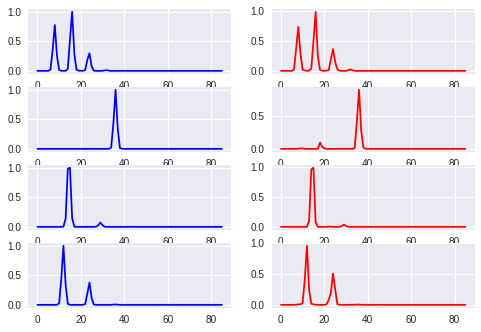

In [14]:
examples_plot = [0, 4, 6, 10]

for i, j in enumerate(examples_plot):
    plt.subplot(len(examples_plot), 2, (i+1)*2-1)
    plt.plot(xx[j], 'b')
    plt.subplot(len(examples_plot), 2, (i+1)*2)
    plt.plot(xr[j], 'r')

In [15]:
yy.shape

(100, 2)

In [16]:
yr.shape

(100, 20)

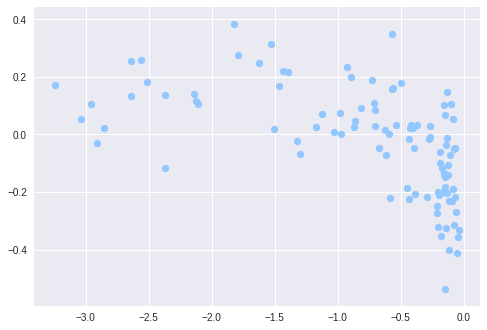

In [17]:
plt.scatter(yy[:,1], yr[:,1])

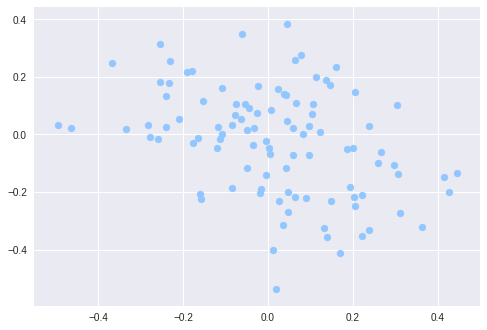

In [18]:
plt.scatter(yr[:,0], yr[:,1])

## Load a bird's data and use it to test

In [19]:
# a batch generator using pandas
birds_sessions = {'z020': ['day-2016-06-02', 'day-2016-06-03', 'day-2016-06-04', 'day-2016-06-05', 'day-2016-06-06'],
                 'z017': ['day-2016-06-17', 'day-2016-06-18', 'day-2016-06-19', 'day-2016-06-20', 'day-2016-06-21', 
                          'day-2016-06-22', 'day-2016-06-23', 'day-2016-06-24', 'day-2016-06-27', 'day-2016-06-28'],
                  'z007': ['day-2016-09-07', 'day-2016-09-09', 'day-2016-09-10', 'day-2016-09-11', 'day-2016-09-12', 
                           'day-2016-09-13', 'day-2016-09-14']
                 }

all_df = []
for bird, sess_list in birds_sessions.items():
    if bird=='z007':
        for sess in sess_list:
            data_file = os.path.join('/mnt/cube/earneodo/bci_zf/ss_data/', bird, sess, 'spectral_pandas.pickle')
            all_df.append(pd.read_pickle(data_file))
bird_df = pd.concat(all_df)

class BirdBatcher(object):
    def __init__(self, data_frame, x_field=None, y_field=None, train_fraction=0.9):
        self.data_frame = data_frame.sample(frac=1)
        self.train_fraction = train_fraction
        self.x_field = x_field
        self.y_field = y_field
        
        self.max_pow = np.amax(data_frame['spectral'].max())
        self._split()
        self._make_train_array()
        self._make_test_array()
        
    def _split(self):
        random_frac = int(self.data_frame.shape[0] * self.train_fraction)
        self.data_frame.fillna(0)
        self.train_frame = self.data_frame[random_frac:]
        self.test_frame = self.data_frame[:random_frac]
        
    def _make_train_array(self):
        all_spectra = np.array(self.train_frame['spectral'].as_matrix())
        self.all_train_array = normalize(np.concatenate([np.array(s) for s in all_spectra], 
                                                        axis=1).T).T
        self.all_label_array = np.arange(self.all_train_array.shape[1])%len(all_spectra[0][1])
        
        no_silence = np.where(np.nansum(self.all_train_array, axis=0)>0)[0]
        self.all_train_array = self.all_train_array[:, no_silence]
        self.all_label_array = self.all_label_array[no_silence]


        
    def _make_test_array(self):
        all_spectra = (np.array(self.test_frame['spectral'].as_matrix()))
        self.all_test_array = np.stack([np.array(s) for s in all_spectra], 
                                                 axis=0)
        
    def train_batch(self, n):
        idx = np.random.randint(0, self.all_train_array.shape[1], n)
        return [self.all_train_array[:, idx].T, self.all_label_array[idx]]
    
    def test_batch(self, n_mot):
        idx = np.random.randint(0, self.all_test_array.shape[0], n_mot)
        test_array_batch = self.all_test_array[idx]
        return test_array_batch

pd_bird = BirdBatcher(bird_df[bird_df.sess=='day-2016-09-10'])
print(bird_df.shape)
x, y = pd_bird.train_batch(b_size)
n_samples = pd_bird.all_train_array.shape[-1]

(306, 6)


/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


In [20]:
s_arr = normalize(pd_bird.all_train_array.T).T

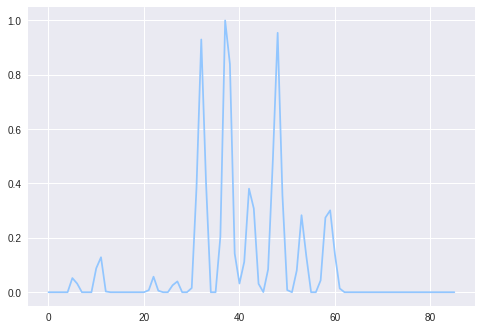

In [21]:
plt.plot(s_arr[:,50])

(86, 3397)


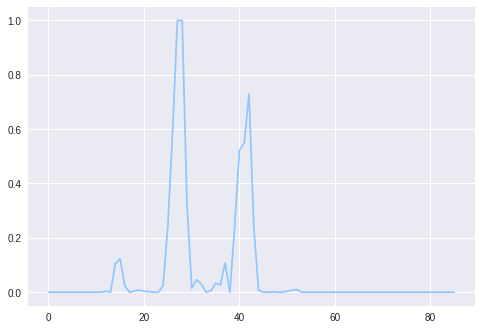

In [22]:
print(pd_bird.all_train_array.shape)
b_size = 150
x, y = pd_bird.train_batch(b_size)
plt.plot(x[3])

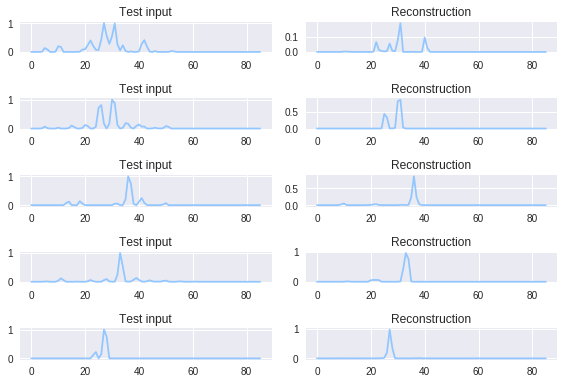

In [23]:
x_sample = pd_bird.train_batch(b_size)[0]
x_reconstruct, _, _ = v.vae(x_sample)
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

In [24]:
x_sample[10]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   2.61148788e-02,
         2.84793516e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   4.28727325e-02,   1.41375720e-01,
         4.80621180e-02,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   9.34220288e-04,   5.44608476e-03,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.69903376e-02,   1.25966190e-01,   6.64931544e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.99989217e-02,   2.57696433e-02,   0.00000000e+00,
         0.00000000e+00,   1.33945992e-02,   3.44455564e-01,
         1.00000000e+00,   7.20512168e-01,   2.15277213e-01,
         1.02577109e-01,   2.16436466e-01,   4.81234600e-01,
         3.92556600e-01,   1.16117316e-01,   1.67535807e-03,
         7.20376220e-05,   3.24223930e-02,   0.00000000e+00,
         3.50566454e-02,   5.19868167e-02,   1.92180579e-03,
         8.30345199e-02,

In [25]:
x_reconstruct.shape

(150, 86)

(2, 86, 589)


/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


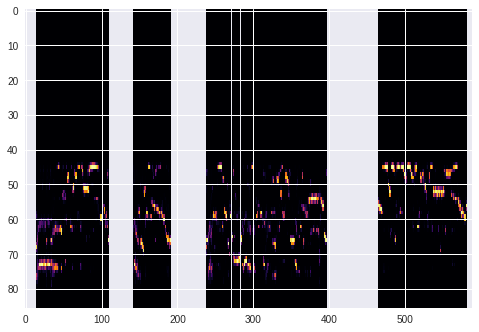

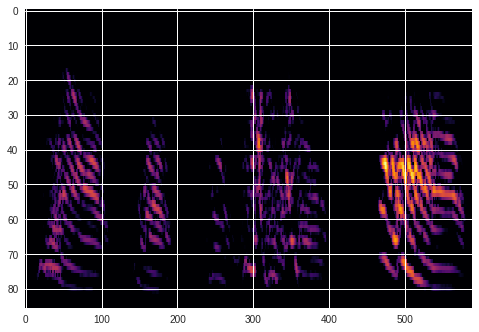

In [26]:
def motiff_reconstruct(n_motiff):
    x_test = pd_bird.test_batch(n_motiff)
    print(x_test.shape)
    x_reconstruct = []
    for i in range(n_motiff):
        
        mot_reconstr, _, _ = v.vae(normalize(x_test[i].T))
        x_reconstruct.append(mot_reconstr.T)
    return np.stack(x_reconstruct, axis=0), x_test

x_r, x_test = motiff_reconstruct(2)
x_r.shape
sample_view = 0
plt.imshow((x_r[sample_view][::-1]), aspect='auto', cmap='inferno')
plt.figure()
plt.imshow(np.log(x_test[sample_view][::-1]), aspect='auto', cmap='inferno')

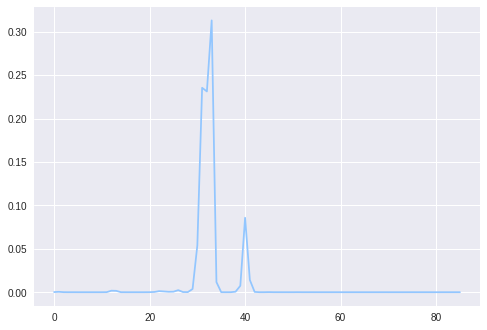

In [27]:
plt.plot(x_r[0][:,50])

/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


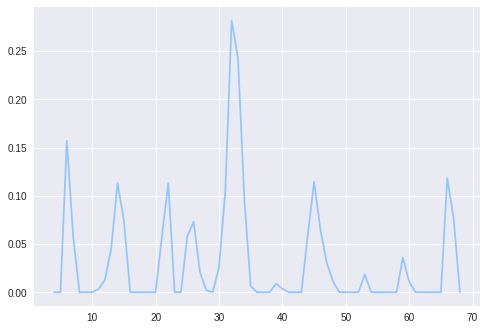

In [28]:
plt.plot(normalize(x_test[0])[:,50])

/home/earneodo/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


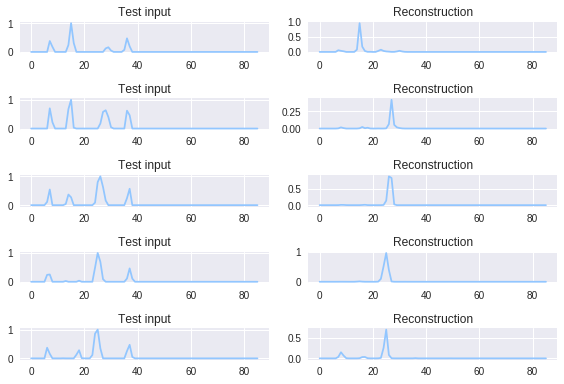

In [29]:
x_sample = normalize(x_test[1][:,150:250].T)
x_reconstruct, _, _ = v.vae(x_sample)
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.plot(x_sample[i])
    plt.title("Test input")
    plt.subplot(5, 2, 2*i + 2)
    plt.plot(x_reconstruct[i])
    plt.title("Reconstruction")
plt.tight_layout()

In [30]:
x_test[0].shape

(86, 589)

In [31]:
x_reconstruct[20]

array([  3.27618582e-05,   2.13353487e-04,   4.03946178e-05,
         7.00929304e-05,   1.50697451e-06,   6.55931809e-10,
         1.64417990e-08,   8.69099324e-07,   7.54047448e-07,
         5.35285790e-06,   1.67789636e-04,   6.88197042e-06,
         4.04468119e-05,   4.51837492e-04,   6.20064441e-07,
         2.88185305e-07,   1.11043857e-06,   6.20695573e-06,
         2.10657390e-07,   7.60255969e-10,   2.98827999e-05,
         1.29274022e-05,   3.41645151e-04,   2.64614727e-02,
         2.84677505e-01,   1.32553205e-02,   6.52029936e-04,
         2.91313263e-05,   4.94273627e-06,   3.02415629e-07,
         2.28005899e-08,   1.59864744e-08,   1.54968147e-05,
         5.75719860e-05,   6.35270262e-04,   8.58265324e-04,
         2.19836645e-02,   3.67523432e-01,   9.47939217e-01,
         1.55599654e-01,   7.61635415e-03,   1.17913689e-04,
         1.95747853e-04,   1.79919196e-04,   1.97479472e-04,
         7.13854461e-05,   3.79570498e-04,   1.48852108e-04,
         3.35372344e-04,

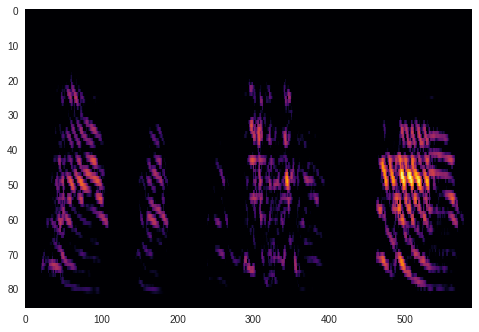

In [32]:
plt.imshow(np.log(x_test[1][::-1]),  aspect='auto', cmap='inferno')
plt.grid(False)